In [1]:
import os
import numpy as np
import pandas as pd
from reportlab.pdfgen import canvas
import matplotlib.pyplot as plt

# in use
import time
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter, landscape, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch

from OBFEinschlag import OBFEinschlag

In [2]:
#path_dir = "/Users/philipp/Code/fe_recognition/bon/data"
path_dir = os.path.join(os.getcwd(), 'data')
data = pd.read_csv(path_dir + "/Hiebssatzbilanz_2018_171.xls", sep='\t', decimal=',', encoding = "ISO-8859-1", error_bad_lines=False)
obf_es = OBFEinschlag(data)
fb = 171

In [3]:
es, hs, bilz, bilz_ub = obf_es.filter_data(fr=[10])

In [4]:
def position(data, kind='all'):
    
    w_p_org, h_p_org = landscape(A4)
    mm = w_p_org/297
    
    if kind == 'all':
        if data < 10:
            pos = mm*3
        elif data < 100:
            pos = mm*4
        else:
            pos = mm*6
            
    elif kind == 'lh':
        if data < 10:
            pos = mm*8
        elif data < 100:
            pos = mm*9
        else:
            pos = mm*11
            
    elif kind == 'nh':
        if data < 10:
            pos = mm*3
        elif data < 100:
            pos = mm*2
        else:
            pos = mm*1
    return(pos)

In [5]:
def make_bilz_hs(obf_es, fr):

    key_data = obf_es.fuc_tbl(fr=[fr])

    c = canvas.Canvas("graph_" + str(fr) + ".pdf",pagesize=landscape(A4))

    # weights
    w_p_org, h_p_org = landscape(A4)

    mm = w_p_org/297
    marg = 15 * mm

    w_p = w_p_org - 2*marg
    h_p = h_p_org - 2*marg

    w_g = w_p/3
    h_g = w_g*1.1
    #h_g = h_p*0.55

    print(w_p_org)
    print(w_p)
    print(w_g)


    #c.drawString(2*inch,2*inch,"Welcome to Reportlab!")

    y_max, y_min = obf_es.max_min([fr])

    ##############
    # graphs
    ##############

    # calc bilanzierter HS 
    es, hs, bilz, bilz_ub = obf_es.filter_data([fr], group=False)
    bilz = obf_es.bilanzierter_HS(es, hs)
    laufzeit, rest_laufzeit, year_start, year_now, hs_year = obf_es.get_time(es, hs)

    for i in [['Ges','Gesamt',0], ['EN','Endnutzung',1], ['VN','Vornutzung',2]]:

        # create table
        table = obf_es.fuc_tbl_hiebsatzbilanz([fr], i, kind='all', y_max=y_max, y_min=y_min)
        #table = obf_es.fuc_tbl_hiebsatzbilanz([1030], [2], i, y_max, y_min)
        #c.drawImage("tempx.png", (i[2]*3+0.3)*inch, 2*inch, width=3*inch, height=2.6*inch)    
    hses = obf_es.fuc_tbl_pie([fr], hs_year*laufzeit)

    for i in [[0,-1.5,-3.5],[1,-0.5,-0.5],[2,0.5,2.5]]:
        c.drawImage("tempx_" + str(i[0]) + ".png", w_p_org*0.5 + i[1]*w_g, marg + h_p*0.15, width=w_g, height=h_g)
        c.drawImage("tempp_" + str(i[0]) + ".png", w_p_org*0.5 + i[2]*w_g/3, marg + h_p*0.71, width=w_g/3, height=w_g/3)

    # create colors for graph
    #laufzeit, rest_laufzeit, year_start, year_now, hs_year = obf_es.get_time(es, hs)
    colors = obf_es.create_colors(laufzeit, rest_laufzeit)
    # calc data_hs_es_percent and plot it
    data_hs_es_percent = obf_es.calc_hs_es_percent(es, hs, bilz)
    obf_es.plot_hs_es_percent(data_hs_es_percent, colors)
    c.drawImage("temp_per.png", w_p_org*0.5 - w_g, marg, width=w_g*2, height=w_g*0.27) 


    ##############
    # draw lines
    ##############

    # coose colors
    c.setStrokeColorRGB(0.2,0.5,0.3)
    c.line(marg, marg, w_p_org - marg, marg)
    c.line(marg, marg + h_p*0.15, w_p_org - marg, marg + h_p*0.15)
    c.line(marg, marg + h_p*0.7, w_p_org - marg, marg + h_p*0.7)
    c.line(marg, marg + h_p*0.88, w_p_org - marg, marg + h_p*0.88)
    c.line(marg, marg + h_p*0.92, w_p_org - marg, marg + h_p*0.92)

    for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
        c.line(i[1] - w_g/2, marg + h_p*0.79, i[1] - w_g/4, marg + h_p*0.79)
        c.line(i[1] + w_g/4, marg + h_p*0.79, i[1] + w_g/2, marg + h_p*0.79)

    c.setFillColorRGB(0.2,0.5,0.3)
    c.rect(marg, h_p_org - marg - mm*10, w_p, mm*10, fill=1)

    c.setStrokeColorRGB(1,1,1)
    c.setFillColorRGB(1,1,1)
    c.rect(w_p_org/2-w_g/2-mm*2.5, marg + h_p*0.65,  mm*5, h_p*0.28 , fill=1)
    c.rect(w_p_org/2+w_g/2-mm*2.5, marg + h_p*0.65,  mm*5, h_p*0.28 , fill=1)
    #c.setStrokeColorRGB(0,0,0)
    #c.line(w_p_org/2, 0, w_p_org/2, h_p)


    ##############
    # text
    ##############

    #
    c.setFont("Helvetica", 8)
    c.setFillColorRGB(0,0,0)
    c.drawString(w_p_org*0.5 - w_g*1.3, marg + h_p*0.016, "Prozent [%]")
    c.setFont("Helvetica", 11)
    c.drawString(w_p_org*0.5 - w_g*1.4, marg + h_p*0.096, "Gesamt Hiebssatz")
    c.drawString(w_p_org*0.5 - w_g*1.4, marg + h_p*0.046, "Gesamt Einschlag")

    c.drawString(w_p_org*0.5 + w_g*1, marg + h_p*0.096, "Laufzeit Teiloperat")
    c.drawString(w_p_org*0.5 + w_g*1.07, marg + h_p*0.046, str(year_start) + " - " + str(year_start+laufzeit-1))



    # percentage
    c.setFont("Helvetica", 14)
    c.setFillColorRGB(0,0,0)
    for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
        es_per = int(round(hses[i[0]][0]/hses[i[0]][1]*100))        
        c.drawString(i[1] - position(es_per), marg + h_p*0.783, str(es_per) + "%")
    # data - HS, ES, Bilz HS
    c.setFont("Helvetica", 14)
    c.setFillColorRGB(0,0,0)
    for i in [[0, w_p_org*0.5-w_g, bilz["Summe"]], [1, w_p_org*0.5, bilz["ENLH"]+bilz["ENNH"]], [2,w_p_org*0.5+w_g, bilz["VNLH"]+bilz["VNNH"]]]:
        # Hiebssatz
        c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.805, str(int(key_data[1][i[0]])))
        # Einschlag
        c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.715, str(int(round(key_data[0][i[0]],0))))
        # Bilanz HS - negativ berücksichtigt
        c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.805, str(int(round(i[2]))))
        # Bilanz HS - negativ nicht berücksichtigt
        c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.715, str(int(round(key_data[2][i[0]],0))))
    # subtitle
    c.setFont("Helvetica", 5)
    c.setFillColorRGB(0,0,0)    
    for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.835, "jährlicher")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.745, "mittlerer jährlicher")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.835, "Negativ berücksichtigt")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.745, "Negativ unberücksichtigt")
    # title
    c.setFont("Helvetica", 9)
    c.setFillColorRGB(0,0,0)
    for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.85, "Hiebssatz")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.76, "Einschlag")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.85, "Bilz Hiebssatz")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.76, "Bilz Hiebssatz")
    # 
    c.setFont("Helvetica", 15)
    c.setFillColorRGB(0,0,0)
    c.drawString(w_p_org*0.5 - w_g - mm*10, marg + h_p*0.89, "Gesamt")
    c.drawString(w_p_org*0.5 - mm*15, marg + h_p*0.89, "Endnutzung")
    c.drawString(w_p_org*0.5 + w_g - mm*15, marg + h_p*0.89, "Vornutzung")
    # define font
    c.setFont("Helvetica", 20)
    c.setFillColorRGB(1,1,1)
    c.drawString(w_p_org*0.5 - mm*24, h_p_org - marg - mm*7.5, "FB " + str(fb) + " - FR " + str(fr))

    c.save()
    print('FB ' + str(fb) + ' - FR ' + str(fr))

In [6]:
# LH / NH

def make_bilz_hs_lh_nh(obf_es, fr):

    key_data = obf_es.fuc_tbl(fr=[fr], kind='lh_nh')

    c = canvas.Canvas("graph_" + str(fr) + "_lh_nh.pdf",pagesize=landscape(A4))

    # weights
    w_p_org, h_p_org = landscape(A4)

    mm = w_p_org/297
    marg = 15 * mm

    w_p = w_p_org - 2*marg
    h_p = h_p_org - 2*marg

    w_g = w_p/3
    h_g = w_g*1.2

    print(w_p_org)
    print(w_p)
    print(w_g)


    #c.drawString(2*inch,2*inch,"Welcome to Reportlab!")

    y_max, y_min = obf_es.max_min([fr])

    # calc bilanzierter HS 
    es, hs, bilz, bilz_ub = obf_es.filter_data([fr], group=False)
    bilz = obf_es.bilanzierter_HS(es, hs)
    laufzeit, rest_laufzeit, year_start, year_now, hs_year = obf_es.get_time(es, hs)

    for i in [['Ges','Gesamt',0], ['EN','Endnutzung',1], ['VN','Vornutzung',2]]:

        # create table
        table = obf_es.fuc_tbl_hiebsatzbilanz([fr], i, kind='lh_nh', y_max=y_max, y_min=y_min)
        #table = obf_es.fuc_tbl_hiebsatzbilanz([1030], [2], i, y_max, y_min)
        #c.drawImage("tempx.png", (i[2]*3+0.3)*inch, 2*inch, width=3*inch, height=2.6*inch)    
    hses = obf_es.fuc_tbl_pie_lh_nh([fr], hs_year*laufzeit)

    for i in [[0,-1.5,-2.5],[1,-0.5,-0.5],[2,0.5,1.5]]:
        c.drawImage("tempx_" + str(i[0]) + ".png", w_p_org*0.5 + i[1]*w_g, marg, width=w_g, height=h_g)
        c.drawImage("temp_lh_nh_" + str(i[0]) + ".png", w_p_org*0.5 + i[2]*w_g/2, marg + h_p*0.62, width=w_g/2, height=w_g/2)

    #es, hs, bilz = obf_es.filter_data([fr], group=False)
    #bilz = obf_es.bilanzierter_HS(es, hs)

    # draw lines

    # coose colors
    c.setStrokeColorRGB(0.2,0.5,0.3)
    c.line(marg, marg, w_p_org - marg, marg)
    c.line(marg, marg + h_p*0.61, w_p_org - marg, marg + h_p*0.61)
    c.line(marg, marg + h_p*0.88, w_p_org - marg, marg + h_p*0.88)
    c.line(marg, marg + h_p*0.92, w_p_org - marg, marg + h_p*0.92)
    for j in [0.7, 0.79]:
        for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
            c.line(i[1] - w_g/2, marg + h_p*j, i[1] - w_g/4, marg + h_p*j)
            c.line(i[1] + w_g/4, marg + h_p*j, i[1] + w_g/2, marg + h_p*j)

    c.setFillColorRGB(0.2,0.5,0.3)
    c.rect(marg, h_p_org - marg - mm*10, w_p, mm*10, fill=1)

    c.setStrokeColorRGB(1,1,1)
    c.setFillColorRGB(1,1,1)
    c.rect(w_p_org/2-w_g/2-mm*2.5, marg + h_p*0.6,  mm*5, h_p*0.33 , fill=1)
    c.rect(w_p_org/2+w_g/2-mm*2.5, marg + h_p*0.6,  mm*5, h_p*0.33 , fill=1)
    #c.line(w_p_org/2, 0, w_p_org/2, h_p)

    # percentage
    c.setFont("Helvetica", 11)
    c.setFillColorRGB(0,0,0)
    for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
        if hses[i[0]][1] == 0:
            es_per_lh = 0
        else:
            es_per_lh = int(round(hses[i[0]][0]/hses[i[0]][1]*100))
        es_per_nh = int(round(hses[i[0]][2]/hses[i[0]][3]*100))
        c.drawString(i[1] - position(es_per_lh, kind='lh'), marg + h_p*0.735, str(es_per_lh) + "%")
        c.drawString(i[1] + position(es_per_nh, kind='nh'), marg + h_p*0.735, str(es_per_nh) + "%")
    # data - HS, ES, Bilz HS
    c.setFont("Helvetica", 14)
    c.setFillColorRGB(0,0,0)
    'ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe'
    for i in [[0, w_p_org*0.5-w_g, bilz["ENLH"]+bilz["VNLH"], bilz["ENNH"]+bilz["VNNH"]], 
              [2, w_p_org*0.5, bilz["ENLH"], bilz["ENNH"]], 
              [4, w_p_org*0.5+w_g, bilz["VNLH"], bilz["VNNH"]]]:
        c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.805, str(int(key_data[1][i[0]])))
        c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.715, str(int(round(key_data[0][i[0]],0))))
        c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.625, str(int(round(i[2],0))))
        c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.805, str(int(key_data[1][i[0]+1])))
        c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.715, str(int(round(key_data[0][i[0]+1],0))))
        c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.625, str(int(round(i[3],0))))
    # subtitle
    c.setFont("Helvetica", 5)
    c.setFillColorRGB(0,0,0)    
    for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.835, "jährlicher")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.745, "mittlerer jährlicher")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.655, "Negativ berücksichtigt")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.835, "jährlicher")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.745, "mittlerer jährlicher")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.655, "Negativ berücksichtigt")
    # title
    c.setFont("Helvetica", 9)
    c.setFillColorRGB(0,0,0)
    for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.85, "Hiebssatz")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.76, "Einschlag")
        c.drawString(i - w_g/2 + mm*5, marg + h_p*0.67, "Bilz Hiebssatz")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.85, "Hiebssatz")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.76, "Einschlag")
        c.drawString(i + w_g/2 - mm*22, marg + h_p*0.67, "Bilz Hiebssatz")
    # 
    c.setFont("Helvetica", 15)
    c.setFillColorRGB(0,0,0)
    c.drawString(w_p_org*0.5 - w_g - mm*10, marg + h_p*0.89, "Gesamt")
    c.drawString(w_p_org*0.5 - mm*15, marg + h_p*0.89, "Endnutzung")
    c.drawString(w_p_org*0.5 + w_g - mm*15, marg + h_p*0.89, "Vornutzung")
    #
    c.setFont("Helvetica", 11)
    c.setFillColorRGB(0,0,0)
    for i in [w_p_org*0.5 - w_g, w_p_org*0.5, w_p_org*0.5 + w_g]:
        c.drawString(i - w_g/2 + mm*10, marg + h_p*0.89, "LH")
        c.drawString(i + w_g/2 - mm*15, marg + h_p*0.89, "NH")
    # define font
    c.setFont("Helvetica", 20)
    c.setFillColorRGB(1,1,1)
    c.drawString(w_p_org*0.5 - mm*24, h_p_org - marg - mm*7.5, "FB " + str(fb) + " - FR " + str(fr))

    c.save()
    print("FB " + str(fb) + " - FR " + str(fr))

841.8897637795277
756.8503937007875
252.28346456692918
[1048]


/Users/philipp/Python/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1037: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: op(x, rvalues))


FB 171 - FR 1048


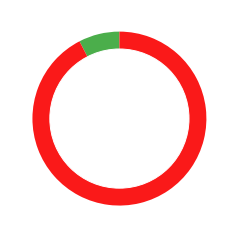

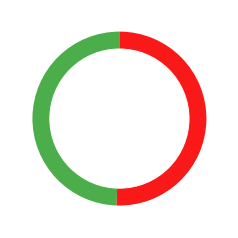

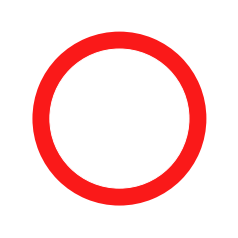

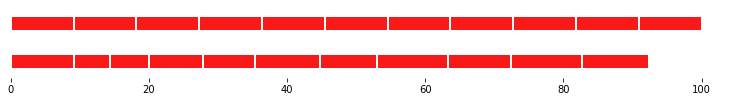

In [8]:
make_bilz_hs(obf_es, 1048)

841.8897637795277
756.8503937007875
252.28346456692918
[1048]


/Users/philipp/Python/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1037: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: op(x, rvalues))


FB 171 - FR 1048


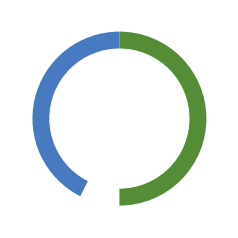

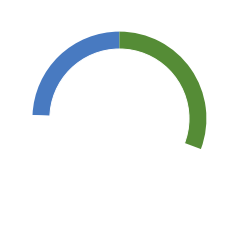

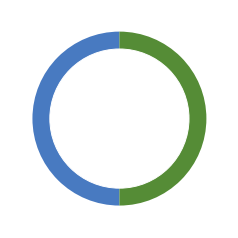

In [6]:
make_bilz_hs_lh_nh(obf_es, 1048)

841.8897637795277
756.8503937007875
252.28346456692918


/Users/philipp/Python/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1037: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: op(x, rvalues))


FB 171 - FR 0
841.8897637795277
756.8503937007875
252.28346456692918
FB 171 - FR 1


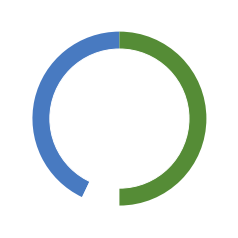

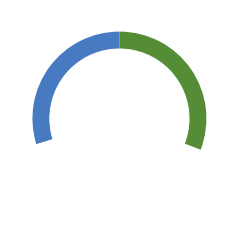

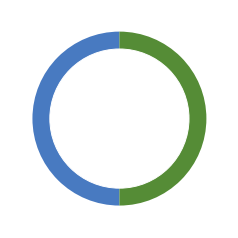

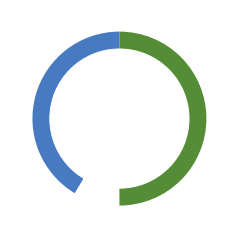

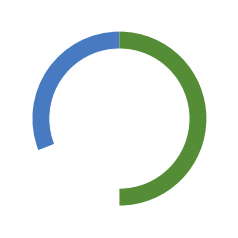

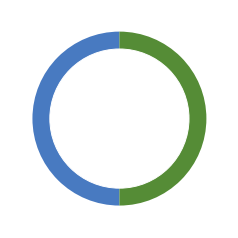

In [6]:
for i in range(2):
    make_bilz_hs_lh_nh(obf_es, i)

841.8897637795277
756.8503937007875
252.28346456692918
[10]
FB 171 - FR 10


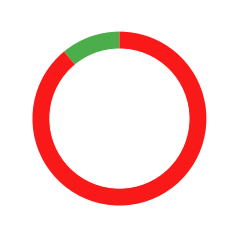

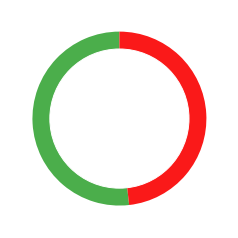

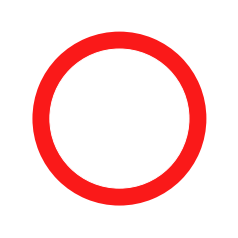

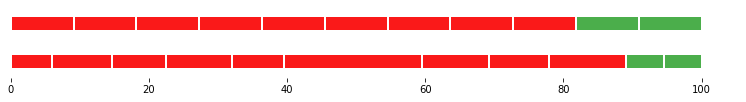

In [9]:
for i in range(10,11):
    make_bilz_hs(obf_es, i)
    #make_bilz_hs_lh_nh(obf_es, i)

In [19]:
hses[0][0]/hses[0][1]

0.8748595515695068

In [20]:
hses[0][2]/hses[0][3]

1.743734117647059

In [21]:
hses

[[97546.84000000001, 111500.0, 14821.740000000002, 8500.0],
 [50461.15, 77100.0, 3223.8199999999997, 2900.0],
 [47085.69000000001, 34400.0, 11597.920000000002, 5600.0]]

In [21]:
es, hs, bilz = obf_es.filter_data([to], [2], group=False)

In [22]:
es.columns

Index(['Hiebssatz Kennzahlty', 'Kennzahl', 'Mandant', 'Forstbetrieb',
       'Teiloperats-ID', 'Forstrevier', 'Betriebsklasse', 'Umtriebszeit',
       'Bewirtschaftungsform', 'Ertragssituation', 'Jahr',
       'Betriebsklassenbez', 'ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe',
       'LfztJahre', 'Einforstung', 'Debitor', 'Angelegt am', 'Angelegt von',
       'Geändert am', 'Geändert von', 'Debitor.1', 'TO-Bezeichnung', 'Status',
       'Beg. Laufzeit', 'Ende Laufzeit'],
      dtype='object')

In [17]:
def bilanzierter_HS(es, hs):
    laufzeit = es['LfztJahre'].iloc[0]
    year_start = es['Jahr'].unique().min()
    year_now = es['Jahr'].unique().max()
    rest_laufzeit = laufzeit - (year_now +1 - year_start)
    
    hs_year = hs[hs['Jahr']==year_now].sum()[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']]
    
    hs_ges = hs_year * laufzeit
    es_sum = es[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()
    hs_sum = hs[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()
    bilz_hs = (hs_ges + es_sum) / rest_laufzeit
    print('hs_ges')
    print(hs_ges)
    print('es_sum')
    print(es_sum)
    
    return(bilz_hs)

In [18]:
bilanzierter_HS(es, hs)

hs_ges
ENLH      68420
ENNH       8580
VNLH      38280
VNNH      16720
Summe    132000
dtype: object
es_sum
ENLH     -57534.53
ENNH      -4870.35
VNLH     -50687.60
VNNH     -27506.22
Summe   -140598.70
dtype: float64


ENLH     10885.5
ENNH     3709.65
VNLH    -12407.6
VNNH    -10786.2
Summe    -8598.7
dtype: object

In [163]:
es_sum = es[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()

In [164]:
hs_sum = hs[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()

In [165]:
hs_year = hs[hs['Jahr']==year_now].sum()[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']]

In [166]:
hs_ges = hs_year * laufzeit

In [167]:
(hs_ges + es_sum) / rest_laufzeit

ENLH     13931.1
ENNH     -133.93
VNLH    -5606.15
VNNH    -2606.15
Summe    5584.82
dtype: object

In [168]:
hs_ges

ENLH      73040
ENNH       6160
VNLH      24200
VNNH       6600
Summe    110000
dtype: object

In [172]:
laufzeit = es['LfztJahre'].iloc[0]

In [173]:
year_now = es['Jahr'].unique().max()

In [174]:
year_start = es['Jahr'].unique().min()

In [175]:
hs_year = key_data[1][0]

In [176]:
hs_ges = hs_year * laufzeit

In [177]:
rest_laufzeit = laufzeit - (year_now +1 - year_start)

In [178]:
(hs_ges + es_sum['Summe'])/rest_laufzeit

33169.64

In [115]:
nhs = hs[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].reset_index()
nes = es[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].reset_index()

In [133]:
bil = nhs + nes

In [134]:
bil.sum()['Summe']

19257.47

In [131]:
bil[bil < 0] = 0

In [132]:
bil.sum()['Summe']

28152.0

In [135]:
28152.0 - 19257.47

8894.529999999999

In [6]:
x = []

y_max, y_min = obf_es.max_min([1030], [2])

for i in [['Ges','Gesamt',0], ['EN','Endnutzung',1], ['VN','Vornutzung',2]]:

    print(i)
    
    ### GET 'TO' FROM FILE
    ### ADD GES = EN + VN
    ### beschriften von Vornutzung und Endnutzung

    # create table
    table = obf_es.fuc_tbl_hiebsatzbilanz_lh_nh([1030], [2], i, y_max, y_min)
    image = plt.imread(os.path.join(os.getcwd(), 'tempx.png'), format=None)
    x.append(image)

['Ges', 'Gesamt', 0]
['EN', 'Endnutzung', 1]
['VN', 'Vornutzung', 2]


In [8]:
table = obf_es.fuc_tbl_hiebsatzbilanz_lh_nh(to=[1030], fr=[2], filterx=['Ges','Gesamt',0])

In [6]:
table = obf_es.fuc_tbl([1030], fr=[2])

In [7]:
table

[[10074.253, 5214.143, 4832.3330000000005], [12000.0, 7000.0, 5000.0]]

In [18]:
(hs['ENLH'].sum()+hs['ENNH'].sum())/hs['Summe'].shape[0]

7000.0

In [15]:
hs['Summe'].sum()/hs['Summe'].shape[0]

12000.0

In [16]:
es['Summe'].sum()/es['Summe'].shape[0]

10074.253

In [9]:
table.max().max()

20465

In [10]:
table.min().min()

-1219

In [7]:
image = plt.imread(os.path.join(os.getcwd(), 'tempx.png'), format=None)

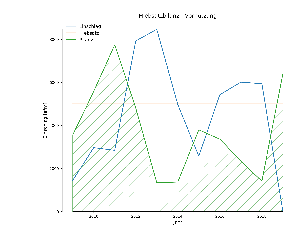

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(x[0])
ax.axis('off')
plt.show()

In [23]:
# important
to = [1030]
fr = [2]

data_filter = data[data['Teiloperats-ID'].isin(to)]

data_filter = data_filter[data_filter['Forstrevier'].isin(fr)]

es = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JES']
hs = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JHS']

es_jahre = es.groupby('Jahr')
hs_jahre = hs.groupby('Jahr')

es_g = es_jahre.sum()*(-1)
hs_g = hs_jahre.sum()
bilz_g = (es-hs).cumsum()*(-1)

In [9]:
# important
def dounat_chart(es_s, hs_s, name):

    if hs_s - es_s < 0:
        diff = 0
    else:
        diff = hs_s - es_s

    fig, ax = plt.subplots()
    ax.pie([diff,es_s], colors=['green', 'red'], labels=['frei', 'genutzt'], startangle=90)

    my_cycle = plt.Circle((0,0),0.7,color='white')
    p = plt.gcf()
    p.gca().add_artist(my_cycle)
    
    plt.savefig('tempp_' + str(name) + '.png', bbox_inches='tight', dpi=300)

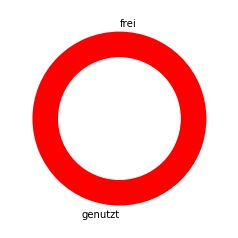

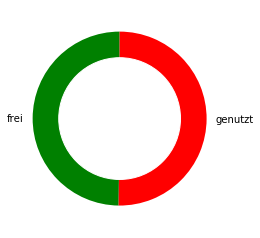

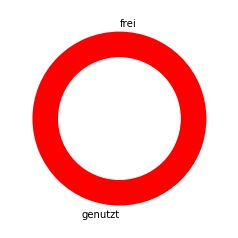

In [10]:
# important
hses = []

for i in ['Ges','EN','VN']:
    
    es_s = 0
    hs_s = 0
    
    if i == 'Ges':
        es_s = es['Summe'].sum()*-1
        hs_s = hs['Summe'].sum()
        dounat_chart(es_s, hs_s, 0)
        hses.append([es_s,hs_s])
        
    elif i == 'EN':
        es_s = (es['ENLH'].sum() + es['ENNH'].sum())*-1
        hs_s = hs['ENLH'].sum() + hs['ENNH'].sum()
        dounat_chart(es_s, hs_s, 1)
        hses.append([es_s,hs_s])
        
    elif i == 'VN':
        es_s = (es['VNLH'].sum() + es['VNNH'].sum())*-1
        hs_s = hs['VNLH'].sum() + hs['VNNH'].sum()
        dounat_chart(es_s, hs_s, 2)
        hses.append([es_s,hs_s])
        

In [23]:
# important
def dounat_chart_lh_nh(es_lh, hs_lh, es_nh, hs_nh, name):

    if hs_lh - es_lh < 0:
        now_lh = 1
        diff_lh = 0
    else:
        now_lh = es_lh/hs_lh
        diff_lh = (hs_lh-es_lh)/hs_lh
        
    if hs_nh - es_nh < 0:
        now_nh = 1
        diff_nh = 0
    else:
        now_nh = es_nh/hs_nh
        diff_nh = (hs_nh-es_nh)/hs_nh

    fig, ax = plt.subplots()
    ax.pie([now_lh, diff_lh, diff_nh, now_nh], colors=['blue', 'white', 'white', 'green'], startangle=90) # colors=['green', 'red'], labels=['frei', 'genutzt'],

    my_cycle = plt.Circle((0,0),0.7,color='white')
    p = plt.gcf()
    p.gca().add_artist(my_cycle)
    
    plt.savefig('templhnh_' + str(name) + '.png', bbox_inches='tight', dpi=300)

In [17]:
es_lh/hs_lh

0.9889395537525354

In [18]:
(hs_lh-es_lh)/hs_lh

0.011060446247464627

In [19]:
es_nh/hs_nh

1.1548673796791444

In [20]:
fr

5

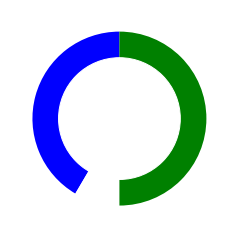

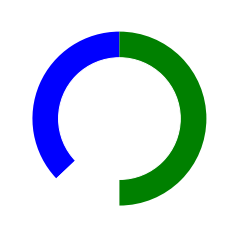

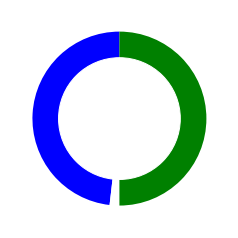

In [25]:
# important
fr = 2
es, hs, bilz = obf_es.filter_data([to], [fr], group=False)

hses = []

for i in ['Ges','EN','VN']:
    
    es_s = 0
    hs_s = 0
    
    if i == 'Ges':
        es_lh = (es['ENLH'].sum() + es['VNLH'].sum())*-1
        hs_lh = (hs['ENLH'].sum() + hs['VNLH'].sum())
        es_nh = (es['ENNH'].sum() + es['VNNH'].sum())*-1
        hs_nh = (hs['ENNH'].sum() + hs['VNNH'].sum())
        dounat_chart_lh_nh(es_lh, hs_lh, es_nh, hs_nh, 0)
        hses.append([es_lh, hs_lh, es_nh, hs_nh])
        
    elif i == 'EN':
        es_lh = (es['ENLH'].sum())*-1
        hs_lh = (hs['ENLH'].sum())
        es_nh = (es['ENNH'].sum())*-1
        hs_nh = (hs['ENNH'].sum())
        dounat_chart_lh_nh(es_lh, hs_lh, es_nh, hs_nh, 1)
        hses.append([es_lh, hs_lh, es_nh, hs_nh])
        
    elif i == 'VN':
        es_lh = (es['VNLH'].sum())*-1
        hs_lh = (hs['VNLH'].sum())
        es_nh = (es['VNNH'].sum())*-1
        hs_nh = (hs['VNNH'].sum())
        dounat_chart_lh_nh(es_lh, hs_lh, es_nh, hs_nh, 2)
        hses.append([es_lh, hs_lh, es_nh, hs_nh])
        

In [12]:
hses

[[100742.53, 120000.0], [52152.56999999999, 70000.0], [48589.96, 50000.0]]

In [21]:
hses[0][0]/hses[0][1]*100

83.95210833333333

In [9]:
c = canvas.Canvas("hello.pdf")
c.drawString(100,750,"Welcome to Reportlab!")
c.save()

In [10]:
import time
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter, landscape, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
 
c = canvas.Canvas("graph_1.pdf",pagesize=landscape(A4))
w_p, h_p = landscape(A4)

c.drawString(2*inch,2*inch,"Welcome to Reportlab!")

#im = Image("tempx.png", width=3*inch, height=2.6*inch)
#c.drawImage("tempx.png",0.2*inch,0.2*inch)
c.drawImage("tempx.png", 0.2*inch, 0.2*inch, width=3*inch, height=2.6*inch)

c.save()


In [13]:
print(w_p)
print(h_p)

841.8897637795277
595.2755905511812


In [14]:
w_cm = 297
h_cm = 210

In [16]:
print(w_p/w_cm)
print(h_p/h_cm)

2.834645669291339
2.834645669291339


In [17]:
round(key_data[0][0],0)

10074.0

841.8897637795277
756.8503937007875
252.28346456692918
20464.980000000003 -1218.67
20464.980000000003 -1218.67
20464.980000000003 -1218.67
[[100742.53, 120000.0], [52152.56999999999, 70000.0], [48589.96, 50000.0]]
end


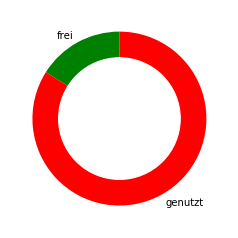

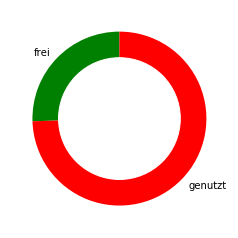

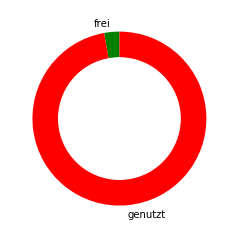

In [6]:
# in use
import time
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter, landscape, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch

key_data = obf_es.fuc_tbl([1030], fr=[2])

c = canvas.Canvas("graph_1.pdf",pagesize=landscape(A4))

# weights
w_p_org, h_p_org = landscape(A4)

mm = w_p_org/297
marg = 15 * mm

w_p = w_p_org - 2*marg
h_p = h_p_org - 2*marg

w_g = w_p/3
h_g = h_p*0.55

print(w_p_org)
print(w_p)
print(w_g)


#c.drawString(2*inch,2*inch,"Welcome to Reportlab!")

y_max, y_min = obf_es.max_min([1030], [2])

for i in [['Ges','Gesamt',0], ['EN','Endnutzung',1], ['VN','Vornutzung',2]]:

    # create table
    table = obf_es.fuc_tbl_hiebsatzbilanz([1030], [2], i, y_max, y_min)
    #table = obf_es.fuc_tbl_hiebsatzbilanz([1030], [2], i, y_max, y_min)
    #c.drawImage("tempx.png", (i[2]*3+0.3)*inch, 2*inch, width=3*inch, height=2.6*inch)    
hses = obf_es.fuc_tbl_pie([1030], [2])

for i in [[0,-1.5,-3.5],[1,-0.5,-0.5],[2,0.5,2.5]]:
    c.drawImage("tempx_" + str(i[0]) + ".png", w_p_org*0.5 + i[1]*w_g, marg + h_p*0.15, width=w_g, height=h_g)
    c.drawImage("tempp_" + str(i[0]) + ".png", w_p_org*0.5 + i[2]*w_g/3, marg + h_p*0.71, width=w_g/3, height=w_g/3)

# draw lines

# coose colors
c.setStrokeColorRGB(0.2,0.5,0.3)
c.line(marg, marg, w_p_org - marg, marg)
c.line(marg, marg + h_p*0.15, w_p_org - marg, marg + h_p*0.15)
c.line(marg, marg + h_p*0.7, w_p_org - marg, marg + h_p*0.7)
c.line(marg, marg + h_p*0.88, w_p_org - marg, marg + h_p*0.88)
c.line(marg, marg + h_p*0.92, w_p_org - marg, marg + h_p*0.92)

for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
    c.line(i[1] - w_g/2, marg + h_p*0.79, i[1] - w_g/4, marg + h_p*0.79)
    c.line(i[1] + w_g/4, marg + h_p*0.79, i[1] + w_g/2, marg + h_p*0.79)

c.setFillColorRGB(0.2,0.5,0.3)
c.rect(marg, h_p_org - marg - mm*10, w_p, mm*10, fill=1)

c.setStrokeColorRGB(1,1,1)
c.setFillColorRGB(1,1,1)
c.rect(w_p_org/2-w_g/2-mm*2.5, marg + h_p*0.65,  mm*5, h_p*0.28 , fill=1)
c.rect(w_p_org/2+w_g/2-mm*2.5, marg + h_p*0.65,  mm*5, h_p*0.28 , fill=1)
#c.line(w_p_org/2, 0, w_p_org/2, h_p)

# text
c.setFont("Helvetica", 14)
c.setFillColorRGB(0,0,0)
for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
    c.drawString(i[1] - mm*4, marg + h_p*0.783, str(int(round(hses[i[0]][0]/hses[i[0]][1]*100))) + "%")
# key data
c.setFont("Helvetica", 14)
c.setFillColorRGB(0,0,0)
for i in [[0,w_p_org*0.5-w_g], [1,w_p_org*0.5], [2,w_p_org*0.5+w_g]]:
    c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.805, str(int(key_data[1][i[0]])))
    c.drawString(i[1] - w_g/2 + mm*5, marg + h_p*0.715, str(int(round(key_data[0][i[0]],0))))
    c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.805, "18300")
    c.drawString(i[1] + w_g/2 - mm*22, marg + h_p*0.715, "13133")
#
c.setFont("Helvetica", 5)
c.setFillColorRGB(0,0,0)    
for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
    c.drawString(i - w_g/2 + mm*5, marg + h_p*0.835, "jährlicher")
    c.drawString(i - w_g/2 + mm*5, marg + h_p*0.745, "mittlerer jährlicher")
    c.drawString(i + w_g/2 - mm*22, marg + h_p*0.835, "Negativ unbrücksichtigt")
    c.drawString(i + w_g/2 - mm*22, marg + h_p*0.745, "Negativ berücksichtigt")
#
c.setFont("Helvetica", 9)
c.setFillColorRGB(0,0,0)
for i in [w_p_org*0.5-w_g, w_p_org*0.5, w_p_org*0.5+w_g]:
    c.drawString(i - w_g/2 + mm*5, marg + h_p*0.85, "Hiebssatz")
    c.drawString(i - w_g/2 + mm*5, marg + h_p*0.76, "Einschlag")
    c.drawString(i + w_g/2 - mm*22, marg + h_p*0.85, "Bilz Hiebssatz")
    c.drawString(i + w_g/2 - mm*22, marg + h_p*0.76, "Bilz Hiebssatz")
#
c.setFont("Helvetica", 15)
c.setFillColorRGB(0,0,0)
c.drawString(w_p_org*0.5 - w_g - mm*10, marg + h_p*0.89, "Gesamt")
c.drawString(w_p_org*0.5 - mm*15, marg + h_p*0.89, "Endnutzung")
c.drawString(w_p_org*0.5 + w_g - mm*15, marg + h_p*0.89, "Vornutzung")
# define font
c.setFont("Helvetica", 20)
c.setFillColorRGB(1,1,1)
c.drawString(w_p_org*0.5 - mm*10, h_p_org - marg - mm*7.5, "FB 171")

c.save()
print('end')

In [14]:
hses

In [52]:
h_p*0.12

61.22834645669292

In [49]:
mm*10

28.34645669291339

In [10]:
for i in range(3):
    print(i)

0
1
2


In [12]:
import time
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
 
doc = SimpleDocTemplate("graph_1.pdf",pagesize=letter,
                        rightMargin=72,leftMargin=72,
                        topMargin=72,bottomMargin=18)
Story=[]
logo = "tempx.png"
magName = "Pythonista"
issueNum = 12
subPrice = "99.00"
limitedDate = "03/05/2010"
freeGift = "tin foil hat"
 
formatted_time = time.ctime()
full_name = "Mike Driscoll"
address_parts = ["411 State St.", "Marshalltown, IA 50158"]
 
im = Image(logo, 2*inch, 2*inch)
Story.append(im)
 
styles=getSampleStyleSheet()
styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))
ptext = '<font size=12>%s</font>' % formatted_time
 
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 12))
 
# Create return address
ptext = '<font size=12>%s</font>' % full_name
Story.append(Paragraph(ptext, styles["Normal"]))       
for part in address_parts:
    ptext = '<font size=12>%s</font>' % part.strip()
    Story.append(Paragraph(ptext, styles["Normal"]))   
 
Story.append(Spacer(1, 12))
ptext = '<font size=12>Dear %s:</font>' % full_name.split()[0].strip()
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 12))
 
ptext = '<font size=12>We would like to welcome you to our subscriber base for %s Magazine! \
        You will receive %s issues at the excellent introductory price of $%s. Please respond by\
        %s to start receiving your subscription and get the following free gift: %s.</font>' % (magName, 
                                                                                                issueNum,
                                                                                                subPrice,
                                                                                                limitedDate,
                                                                                                freeGift)
Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))
 
 
ptext = '<font size=12>Thank you very much and we look forward to serving you.</font>'
Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))
ptext = '<font size=12>Sincerely,</font>'
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 48))
ptext = '<font size=12>Ima Sucker</font>'
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 12))
doc.build(Story)

In [16]:
data.head(7)

,Hiebssatz Kennzahlty,Kennzahl,Mandant,Forstbetrieb,Teiloperats-ID,Forstrevier,Betriebsklasse,Umtriebszeit,Bewirtschaftungsform,Ertragssituation,...,Debitor,Angelegt am,Angelegt von,Geändert am,Geändert von,Debitor.1,TO-Bezeichnung,Status,Beg. Laufzeit,Ende Laufzeit
0,JHS,Festgesetzte Jahreshiebssätze,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
1,JES,Jahres-Einschlag zum Hiebssatz,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
2,JHS,Festgesetzte Jahreshiebssätze,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
3,JES,Jahres-Einschlag zum Hiebssatz,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
4,JHS,Festgesetzte Jahreshiebssätze,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
5,JES,Jahres-Einschlag zum Hiebssatz,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019
6,JHS,Festgesetzte Jahreshiebssätze,1,171,1030,1,9010,100,W,A,...,220442,00.00.0000,NaN,00.00.0000,NaN,220442,1,2,01.01.2009,31.12.2019


In [84]:
to = [1030]
fr = [2]

data_filter = data[data['Teiloperats-ID'].isin(to)]

data_filter = data_filter[data_filter['Forstrevier'].isin(fr)]

es = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JES']
hs = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JHS']

es_jahre = es.groupby('Jahr')
hs_jahre = hs.groupby('Jahr')

es_g = es_jahre.sum()*(-1)
hs_g = hs_jahre.sum()
bilz_g = (es-hs).cumsum()*(-1)

In [19]:
data_filter.columns

Index(['Hiebssatz Kennzahlty', 'Kennzahl', 'Mandant', 'Forstbetrieb',
       'Teiloperats-ID', 'Forstrevier', 'Betriebsklasse', 'Umtriebszeit',
       'Bewirtschaftungsform', 'Ertragssituation', 'Jahr',
       'Betriebsklassenbez', 'ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe',
       'LfztJahre', 'Einforstung', 'Debitor', 'Angelegt am', 'Angelegt von',
       'Geändert am', 'Geändert von', 'Debitor.1', 'TO-Bezeichnung', 'Status',
       'Beg. Laufzeit', 'Ende Laufzeit'],
      dtype='object')

In [20]:
data_filter['Jahr'].unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [21]:
data_filter['Forstrevier'].unique()

array([2])

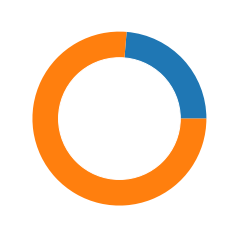

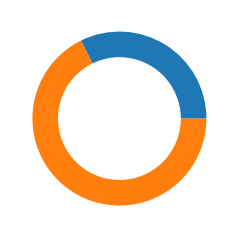

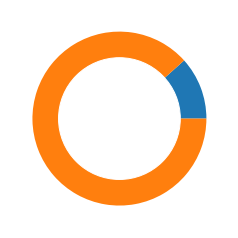

In [115]:
hses = []

for i in ['Ges','EN','VN']:
    
    es_s = 0
    hs_s = 0
    
    if i == 'Ges':
        es_s = es['Summe'].sum()*-1
        hs_s = hs['Summe'].sum()
        dounat_chart(es_s, hs_s, 0)
        hses.append([es_s,hs_s])
        
    elif i == 'EN':
        es_s = (es['ENLH'].sum() + es['ENNH'].sum())*-1
        hs_s = hs['ENLH'].sum() + hs['ENNH'].sum()
        dounat_chart(es_s, hs_s, 1)
        hses.append([es_s,hs_s])
        
    elif i == 'VN':
        es_s = (es['VNLH'].sum() + es['VNNH'].sum())*-1
        hs_s = hs['VNLH'].sum() + hs['VNNH'].sum()
        dounat_chart(es_s, hs_s, 2)
        hses.append([es_s,hs_s])
        

In [104]:
hses

[[100742.53, 132000.0], [52152.57, 77000.0], [48589.96, 55000.0]]

In [107]:
hses[1][1] + hses[2][1]

132000.0

In [82]:
es_s = es_g['Summe'].sum()

In [33]:
hs_s = hs_g['Summe'].sum()

In [114]:
def dounat_chart(es_s, hs_s, name):

    if hs_s - es_s < 0:
        diff = 0
    else:
        diff = hs_s - es_s

    fig, ax = plt.subplots()
    ax.pie([diff,es_s])

    my_cycle = plt.Circle((0,0),0.7,color='white')
    p = plt.gcf()
    p.gca().add_artist(my_cycle)
    
    plt.savefig('tempp_' + str(name) + '.png', bbox_inches='tight', dpi=300)
    plt.show()

In [108]:
int(round(es_s/hs_s*100,0))

88

In [48]:
es_g['Summe']

Jahr
2009     8219.23
2010     8458.19
2011     9187.04
2012    10488.14
2013    10322.25
2014     9873.91
2015    10313.40
2016    10077.22
2017    10920.25
2018    12882.90
2019       -0.00
Name: Summe, dtype: float64

In [16]:
hs_g['Summe']

NameError: name 'hs_g' is not defined

In [8]:
to = [1030]
fr = [2]

data_filter = data[data['Teiloperats-ID'].isin(to)]

data_filter = data_filter[data_filter['Forstrevier'].isin(fr)]

es = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JES']
hs = data_filter[data_filter['Hiebssatz Kennzahlty'] == 'JHS']

es_jahre = es.groupby('Jahr')
hs_jahre = hs.groupby('Jahr')

es_g = es_jahre.sum()*(-1)
hs_g = hs_jahre.sum()
bilz_g = (es-hs).cumsum()*(-1)

In [9]:
new = es_g.loc[:,['Summe']]

In [10]:
new['HS'] = hs_g['Summe']

In [11]:
new

,Summe,HS
Jahr,,
2009,8219.23,12000.0
2010,8458.19,12000.0
2011,9187.04,12000.0
2012,10488.14,12000.0
2013,10322.25,12000.0
2014,9873.91,12000.0
2015,10313.40,12000.0
2016,10077.22,12000.0
2017,10920.25,12000.0


In [17]:
def hs_es_percent(es, hs):
    
    # calculate needed variables
    laufzeit = es['LfztJahre'].iloc[0]
    year_start = es['Jahr'].unique().min()
    year_now = es['Jahr'].unique().max()
    rest_laufzeit = laufzeit - (year_now +1 - year_start)
    
    hs_year = hs[hs['Jahr']==year_now].sum()[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']]
    
    # HS
    hs_garph = np.ones(laufzeit) * hs_year['Summe']
    # index
    index_graph = np.arange(year_start, year_start+laufzeit)
    # create HS dataframe with years as index
    hs_garph = pd.DataFrame(hs_garph, index=index_graph, columns=['gesamt HS'])
    
    # ES
    es_g = es.groupby('Jahr').sum()*(-1)
    es_garph = es_g.loc[:,['Summe']]
    es_garph.columns = ['gesamt ES']
    
    # concatonate HS & ES
    all_graph = pd.concat([es_garph, hs_garph], axis=1)
    # fill nan with bilanz HS
    all_graph = all_graph.fillna(bilz_hs['Summe'])
    # compute percentage
    all_graph = all_graph/hs_garph.sum()[0] * 100
    
    return(all_graph)

In [18]:
def plot_hs_es_percent(data, col):
    #fig = plt.figure(figsize=(9,2))
    #ax = fig.add_subplot(111)

    #ax.bar(new['Summe'], height=0.3, stacked=True, color=color, edgecolor = "green")

    fig, ax = plt.subplots()
    #ax.pie([diff,es_s], colors=['green', 'red'], labels=['frei', 'genutzt'], startangle=90)
    data.T.plot(kind='barh', ax=ax, width=0.2, stacked=True, color=col, edgecolor = 'white', linewidth=2, figsize=(12,1.5), legend=False)
    #ax.set_xlabel('Procent [%]')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    plt.show

In [19]:
def get_colors(laufzeit, rest_laufzeit):
    col = []
    for i in range(laufzeit-rest_laufzeit):
        col.append('red')
    for i in range(rest_laufzeit):
        col.append('green')
    return(col)

In [20]:
data = hs_es_percent(es, hs)

NameError: name 'bilz_hs' is not defined

In [10]:
col = get_colors(11, 1)

TypeError: Empty 'DataFrame': no numeric data to plot

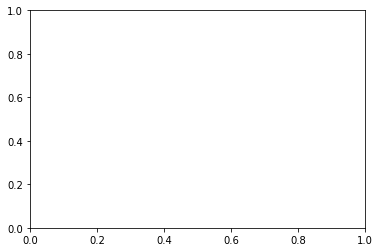

In [11]:
plot_hs_es_percent(data, col)

In [110]:
data

,gesamt ES,gesamt HS
2009,8219.23,12000.0
2010,8458.19,12000.0
2011,9187.04,12000.0
2012,10488.14,12000.0
2013,10322.25,12000.0
2014,9873.91,12000.0
2015,10313.40,12000.0
2016,10077.22,12000.0
2017,10920.25,12000.0
2018,12882.90,12000.0


In [15]:

laufzeit = es['LfztJahre'].iloc[0]
year_start = es['Jahr'].unique().min()
year_now = es['Jahr'].unique().max()
rest_laufzeit = laufzeit - (year_now +1 - year_start)
    
hs_year = hs[hs['Jahr']==year_now].sum()[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']]
    
hs_ges = hs_year * laufzeit
es_sum = es[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()
hs_sum = hs[['ENLH', 'ENNH', 'VNLH', 'VNNH', 'Summe']].sum()
bilz_hs = (hs_ges + es_sum) / rest_laufzeit
print('hs_ges')
print(hs_ges)
print('es_sum')
print(es_sum)

hs_ges
ENLH      75900
ENNH       1100
VNLH      51040
VNNH       3960
Summe    132000
dtype: object
es_sum
ENLH     -51141.43
ENNH      -1011.14
VNLH     -44723.33
VNNH      -3866.63
Summe   -100742.53
dtype: float64


In [16]:
laufzeit

11

In [19]:
hs_year['Summe']

12000.0

In [24]:
# HS
hs_garph = np.ones(laufzeit) * hs_year['Summe']

In [38]:
# index
index_graph = np.arange(year_start, year_start+laufzeit)

In [39]:
hs_garph = pd.DataFrame(hs_garph, index=index_graph, columns=['HS'])

In [40]:
hs_garph

,HS
2009,12000.0
2010,12000.0
2011,12000.0
2012,12000.0
2013,12000.0
2014,12000.0
2015,12000.0
2016,12000.0
2017,12000.0
2018,12000.0


In [27]:
es_garph = es_g.loc[:,['Summe']]

In [30]:
bilz_garph = np.ones(rest_laufzeit) * bilz_hs['Summe']

In [34]:
bilz_garph = pd.DataFrame(bilz_garph, index=[2019], columns=['Summe'])

In [36]:
es_bilz_garph = es_garph.append(bilz_garph)

In [96]:
all_graph = pd.concat([hs_garph, es_bilz_garph], axis=1)

In [97]:
all_graph = all_graph/hs_garph.sum()[0] * 100

In [98]:
all_graph

,HS,Summe
2009,9.090909,6.226689
2010,9.090909,6.407720
2011,9.090909,6.959879
2012,9.090909,7.945561
2013,9.090909,7.819886
2014,9.090909,7.480235
2015,9.090909,7.813182
2016,9.090909,7.634258
2017,9.090909,8.272917
2018,9.090909,9.759773


In [53]:
test_graph = pd.concat([es_garph, hs_garph], axis=1)

In [54]:
all_graph = test_graph.fillna(bilz_hs['Summe'])

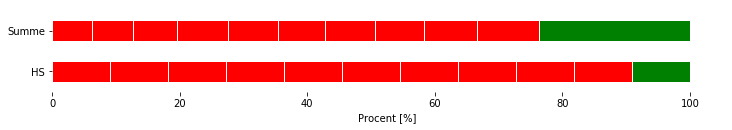

In [100]:
#fig = plt.figure(figsize=(9,2))
#ax = fig.add_subplot(111)

#ax.bar(new['Summe'], height=0.3, stacked=True, color=color, edgecolor = "green")

fig, ax = plt.subplots()
#ax.pie([diff,es_s], colors=['green', 'red'], labels=['frei', 'genutzt'], startangle=90)
all_graph.T.plot(kind='barh', ax=ax, stacked=True, color=col, edgecolor = 'white', figsize=(12,1.5), legend=False)
ax.set_xlabel('Procent [%]')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

In [48]:
color=['lightred','lightred','lightred','lightred','lightred','lightred','lightred','lightred','lightred','lightred','lightgreen']

In [60]:
col = []
for i in range(laufzeit-rest_laufzeit):
    col.append('red')
for i in range(rest_laufzeit):
    col.append('green')


In [63]:
col_edge = []
for i in range(laufzeit-rest_laufzeit):
    col_edge.append('darkred')
for i in range(rest_laufzeit):
    col_edge.append('darkgreen')

In [66]:
col

['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green']

[Text(0, 0, 'G1'),
 Text(0, 0, 'G2'),
 Text(0, 0, 'G3'),
 Text(0, 0, 'G4'),
 Text(0, 0, 'G5')]

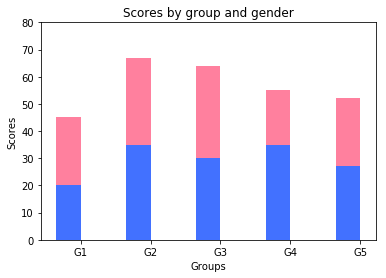

In [39]:
#import plotly.plotly as py
#import plotly.tools as tls

import matplotlib.pyplot as plt
import numpy as np

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, menMeans, width, color=(0.2588,0.4433,1.0))
p2 = ax.bar(ind, womenMeans, width, color=(1.0,0.5,0.62),
             bottom=menMeans)
ax.set_ylabel('Scores')
ax.set_xlabel('Groups')
ax.set_title('Scores by group and gender')

ax.set_xticks(ind + width/2.)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

#plotly_fig = tls.mpl_to_plotly( mpl_fig )

# For Legend
#plotly_fig["layout"]["showlegend"] = True
#plotly_fig["data"][0]["name"] = "Men"
#plotly_fig["data"][1]["name"] = "Women"
#py.iplot(plotly_fig, filename='stacked-bar-chart')

In [6]:
data.loc[data['Hiebssatz Kennzahlty']=='JHS', 'Summe'].sum()

1515500.44

In [40]:
es, hs, bilz = obf_es.filter_data([0], group=True)

In [41]:
hs['Summe'].sum()

1515500.44

In [42]:
data['Jahr'].max()

2018

In [43]:
hs['Summe'].sum()/hs['Summe'].shape[0] 

137772.76727272727

In [44]:
(hs['ENLH'].sum()+hs['ENNH'].sum())/hs['Summe'].shape[0]

79607.29272727271

In [45]:
(hs['VNLH'].sum()+hs['VNNH'].sum())/hs['Summe'].shape[0]

58165.47454545454

In [46]:
hs['Summe'].shape[0] 

11

In [51]:
hs

,Mandant,Forstbetrieb,Teiloperats-ID,Forstrevier,Betriebsklasse,Umtriebszeit,Betriebsklassenbez,ENLH,ENNH,VNLH,VNNH,Summe,LfztJahre,Einforstung,Debitor,Angelegt von,Geändert von,Debitor.1,TO-Bezeichnung,Status
Jahr,,,,,,,,,,,,,,,,,,,,
2008,26,4446,27248,197,234460,3280,0.0,21977.93,3692.09,13512.94,6117.08,45300.04,286,0.0,5731492,0.0,0.0,5731492,0,52
2009,61,10431,63298,302,550060,7580,0.0,55827.93,7042.09,30752.94,11277.08,104900.04,671,0.0,13446962,0.0,0.0,13446962,35,122
2010,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2011,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2012,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2013,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2014,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2015,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230
2016,115,19665,119944,920,1037324,15060,0.0,71497.93,15962.09,42502.94,21737.08,151700.04,1265,0.0,25350830,0.0,0.0,25350830,143,230


In [52]:
hs.loc[data['Jahr'].max(), 'Summe']

151700.03999999998